# Exploring dataset

In [1]:
#1.Let's begin by reading train_labels.csv and printing out its head
import pandas as pd

path2csv = r"D:\my file\ptcv\ptcv2\data\train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
#2.Let's count the number of normal and malignant cases
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


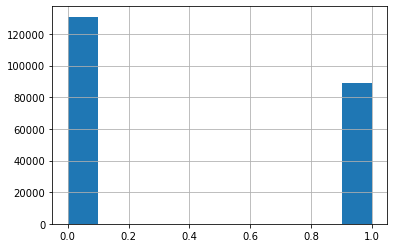

In [3]:
#3.Let's look at the histogram of labels
import matplotlib.pyplot as plt
%matplotlib inline

labels_df['label'].hist()

In [4]:
#4.Let's view some images that have positive labels
#A positive label shows that the center 32x32 region of an image contains at least one pixel of tumor tissue
from PIL import Image, ImageDraw
import numpy as np
import os

In [5]:
#get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

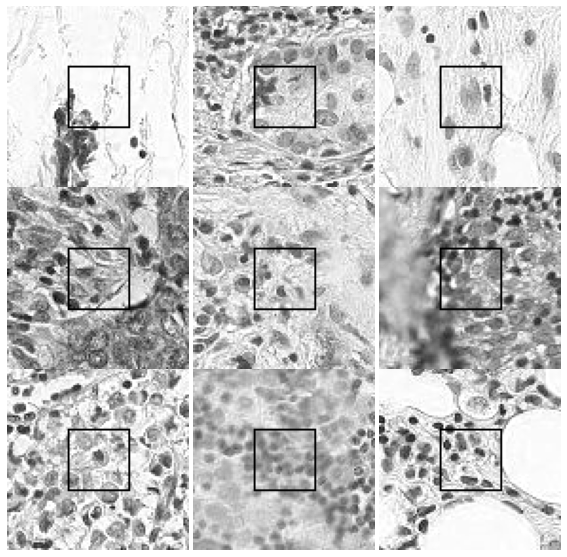

In [6]:
#Define the path to train
path2train = r"D:\my file\ptcv\ptcv2\data\train"

#Next, we define a flag to show images in grayscale or color mode
color = False

#Next, we set the figure size
plt.rcParams['figure.figsize']=(10.0,10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3,3

#Next, we display the iamges
for i, id_ in enumerate(malignantIds[0: nrows*ncols]):
    full_filenames = os.path.join(path2train, id_ +'.tif')
    
    img = Image.open(full_filenames)
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32),(64,64)), outline='green')
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0], cmap="gray")
    plt.axis("off")
    

In [7]:
#5.Let's get some image shape and minimum and maximun pixel values
print("image shape", np.array(img).shape)
print("pixel value have the range of %f to %f "%(np.min(img),np.max(img)))

image shape (96, 96, 3)
pixel value have the range of 0.000000 to 255.000000 


# Creating a cumstom dataset
We can create a custom dataset class by subclassing the PyTorch *Dataset* class
<br>When creating a custom dataset, maek sure to define 2 essential functions: \_\_len\_\_ and \_\_getitem\_\_
<br>The \_\_len\_\_function returns the length of dataset, is callable with Python *len* function
<br>The \_\_getitem\_\_function return a image at specific index

In [8]:
#1.Let's create a PyTorch custom dataset for our data
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

#Don't forget to fix the random seed reproducibility
torch.manual_seed(0)

#Define histoCancerDataset class
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        path2data = os.path.join(data_dir, data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        csv_file = data_type + "_labels.csv"
        path2csvLabels = os.path.join(data_dir, csv_file)
        labels_df = pd.read_csv(path2csvLabels)
        labels_df.set_index("id", inplace=True)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [9]:
#2.Next, we will define a simple transformation that only transform images to PyTorch tensors
data_transformer = transforms.Compose([transforms.ToTensor()])

In [10]:
#3.Then , we will define an object from histoCancerDataset for the train folder
data_dir = r"D:\my file\ptcv\ptcv2\data"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
len(histo_dataset)

220025

In [11]:
#4.Next, we will load an image using custom dataset
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


# Splitting the dataset
We need to provide a validation set to track the model's performance during training
<br>We use 20% of histo_dataset as the validation set and the rest for training

In [12]:
#1.Let's split histo_dataset
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])
print("train set length",len(train_ds))
print("val set length", len(val_ds))

train set length 176020
val set length 44005


In [13]:
#2.Then we can get an image from training dataset
for x,y in train_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


In [14]:
#3.We also can get an image from validation dataset
for x,y in val_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


image indices [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


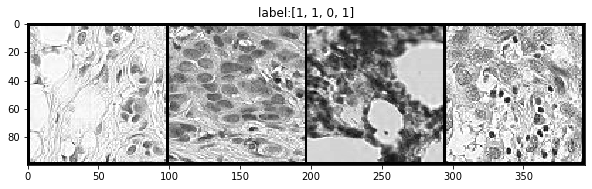

In [15]:
#4.Let's display a few samples from trian_ds
from torchvision import utils
np.random.seed(0)

#Define a helper function to show an image
def show(img, y, color=False):
    #convert a tensor to numpy array
    npimg = img.numpy()
    #convert to H*W*C shape
    npimg_tr = np.transpose(npimg, (1,2,0))
    if color == False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap="gray")
    else:
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title("label:"+str(y))

#create a grid of sample images
grid_size=4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print("image indices",rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

#call the helper function to display the grid
plt.rcParams['figure.figsize'] = (10,5)
show(x_grid_train, y_grid_train)

[30403 32103 41993 20757]
torch.Size([3, 100, 394])


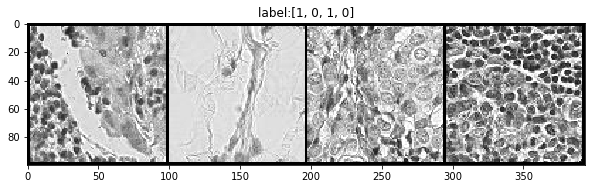

In [16]:
#5.We can also show some sample from val_ds
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print(rnd_inds)

x_grid_val = [val_ds[i][0] for i in rnd_inds]
y_grid_val = [val_ds[i][1] for i in rnd_inds]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val, y_grid_val)

# Transforming the data
Image transformation and image augmentation are necessary for training deeplearning models
<br>Typical transformations include horizontal and vertical flipping, rotation and resizing
<br>We will use the *torchvision* package to perform on-the-fly image transformation during training

In [17]:
#1.First, let's define the following transformations for the training dataset
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8,1.0), ratio=(1.0,1.0)),
    transforms.ToTensor()
])

In [18]:
#2.For the validaiton set, we don't need any augmentation,so we only convert the images into tensor
val_transformer = transforms.Compose([transforms.ToTensor()])

In [19]:
#3.After defining the transformer, we override the transform functions of train_ds and val_ds
train_ds.transform = train_transformer
val_ds.transform = val_transformer

# Creating dataloaders

In [20]:
#1.First, let's define 2 dataloaders for the datasets
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False,pin_memory=True)

In [21]:
len(val_ds)

44005

In [22]:
#2.Then, we get a data batch from the training dataloader
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([256, 3, 96, 96])
torch.Size([256])


In [23]:
#3.Next, we get a data batch from the validation dataloader
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([256, 3, 96, 96])
torch.Size([256])


# Building the classfication model
Our model is comprised of 4 CNNs and 2 fully connected layers
<br>After each convolutional layer, there is a pooling layer
<br>The convolutional layer precess the input image and extract the feature vector,which is fed to fully connected layers<br>There is an output layer for the binary classification

Now, we will define the model, move it into CUDA device, and get a model summary

In [24]:
#1.First, let's create the dumb baselines for the validation dataset
#First we get the labels for the validation dataset
y_val = [y for _,y in val_ds]

#Next, we will define a function to calculate the classification accuracy
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))


In [25]:
#Then, we will calculate a dumb baseline for all-zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction",acc_all_zeros)

accuracy all zero prediction 0.5946369730712419


In [26]:
#Next, we will calculate a dumb baseline for all-one predictions
acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print("accuracy all one prediction", acc_all_ones)

accuracy all one prediction 0.4053630269287581


In [27]:
#Next, we will calculate a dumb baseline for random predictions
acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))
print("accuracy random prediction", acc_random)

accuracy random prediction 0.49776161799795476


In [28]:
#2.Let's implement a helper function to calculate the output size of CNN layer
import torch.nn as nn
import numpy as np

#Then, we will define the helper function
def findConv2dOutShape(H_in, W_in, conv, pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    H_out = np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    if pool:
        H_out /= pool
        W_out /= pool
    return int(H_out), int(W_out)

In [29]:
#Next, we will look at the helper function using an examlpe
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w = findConv2dOutShape(96, 96, conv1)
print(h,w)

47 47


In [30]:
#3.Next, we will implement the CNN model
import torch.nn as nn
import torch.nn.functional as F

#Define the Net class
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in,H_in,W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv4)
        
        #Compute the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [31]:
#4.Then, we will construct an object of Net class
params_model = {
    "input_shape":(3,96,96),
    "initial_filters":8,
    "num_fc1":100,
    "dropout_rate":0.25,
    "num_classes":2
}

#create model
cnn_model = Net(params_model)


In [32]:
#5.Move the model into CUDA device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)
    print("move to CUDA success")

move to CUDA success


In [33]:
#6.Print the model
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [34]:
#7.Verify the model device
print(next(cnn_model.parameters()).device)

cuda:0


In [35]:
#8.Let's get summary of the model
from torchsummary import summary
summary(cnn_model, input_size=(3,96,96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


# Defining the loss function

In [36]:
#1.First, let's define the loss function ,as follows
loss_func = nn.NLLLoss(reduction="sum")

In [37]:
#2.Next, we will use the loss in an example
torch.manual_seed(0)

n,c = 8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out = ls_F(y)
print(y_out.shape)

target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())


torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [38]:
#3.Then, we will compute the gradients of the loss with respect to y
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining the optimizer

In [39]:
#1.First, let's define an object of Adam optimizer with learning rate of 3e-4
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [40]:
#2.We can read the current value of learning rate using the following function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]
    
current_lr = get_lr(opt)
print("current lr", current_lr)

current lr 0.0003


In [41]:
#3.Next, we will define a learning rate scheduler using the ReduceLROnPlateau method
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)


In [42]:
#4.Then we will learn how the learning rate schedule works using the following example
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


# Training and evaluation of the model

In [43]:
#1.First, let's develop a helper function to count the number of correct predictions per data batch
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [44]:
#2.Then, we will develop a helper function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [45]:
#3.Next, we will define a helper function to loss value and the performance metrics for an epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        running_loss += loss_b
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
        
    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

In [46]:
#4.Then develop the train_val function in the followings
def train_val(model, params):
    #First, we extrcat the model parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    #Then, we define 2 dictionaries to keep a history of loss values and accuracy values
    loss_history = {
        "train":[],
        "val":[]
    }
    
    metric_history = {
        "train":[],
        "val":[]
    }
    
    #Next,  we create a copy of state_dict
    #a deepcopy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    #Then we will initalize the best loss to an infinite value
    best_loss = float('inf')
    
    #Next, we define a loop that will the training loss over an epoch
    for epoch in range(num_epochs):
        start = time.time()
        current_lr = get_lr(opt)
        print("Epoch %d/%d, current lr %f"%(epoch, num_epochs-1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights")
            model.load_state_dict(best_model_wts)
        
        end = time.time()
        print("train loss %.6f, dev loss %.6f, accuracy %.2f, duration %.4f sec"
              %(train_loss, val_loss, val_metric, end-start))
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [47]:
#5.Let's set sanity_check to True and run the code
import copy
import time
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

params_train = {
    "num_epochs":100,
    "loss_func":loss_func,
    "optimizer":opt,
    "train_dl":train_dl,
    "val_dl":val_dl,
    "sanity_check":True,
    "lr_scheduler":lr_scheduler,
    "path2weights":r"D:\my file\ptcv\ptcv2\models\weights.pt"
}

#train and validate the model
cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/99, current lr 0.000300
Copied best model weights!
train loss 0.001020, dev loss 0.004073, accuracy 0.00, duration 0.4880 sec
Epoch 1/99, current lr 0.000300
Copied best model weights!
train loss 0.001018, dev loss 0.004056, accuracy 0.00, duration 0.4259 sec
Epoch 2/99, current lr 0.000300
Copied best model weights!
train loss 0.001015, dev loss 0.004040, accuracy 0.00, duration 0.3910 sec
Epoch 3/99, current lr 0.000300
Copied best model weights!
train loss 0.001010, dev loss 0.004026, accuracy 0.00, duration 0.3955 sec
Epoch 4/99, current lr 0.000300
Copied best model weights!
train loss 0.001007, dev loss 0.004013, accuracy 0.00, duration 0.4029 sec
Epoch 5/99, current lr 0.000300
Copied best model weights!
train loss 0.001000, dev loss 0.003998, accuracy 0.00, duration 0.4289 sec
Epoch 6/99, current lr 0.000300
Copied best model weights!
train loss 0.000993, dev loss 0.003983, accuracy 0.00, duration 0.3910 sec
Epoch 7/99, current lr 0.000300
Copied best model weights!
tra

Copied best model weights!
train loss 0.000901, dev loss 0.003608, accuracy 0.00, duration 0.3905 sec
Epoch 64/99, current lr 0.000300
Copied best model weights!
train loss 0.000868, dev loss 0.003589, accuracy 0.00, duration 0.3862 sec
Epoch 65/99, current lr 0.000300
Copied best model weights!
train loss 0.000878, dev loss 0.003575, accuracy 0.00, duration 0.3903 sec
Epoch 66/99, current lr 0.000300
Copied best model weights!
train loss 0.000922, dev loss 0.003548, accuracy 0.00, duration 0.4971 sec
Epoch 67/99, current lr 0.000300
Copied best model weights!
train loss 0.000895, dev loss 0.003518, accuracy 0.00, duration 0.3728 sec
Epoch 68/99, current lr 0.000300
Copied best model weights!
train loss 0.000865, dev loss 0.003488, accuracy 0.00, duration 0.3905 sec
Epoch 69/99, current lr 0.000300
Copied best model weights!
train loss 0.000902, dev loss 0.003464, accuracy 0.00, duration 0.4470 sec
Epoch 70/99, current lr 0.000300
Copied best model weights!
train loss 0.000873, dev los

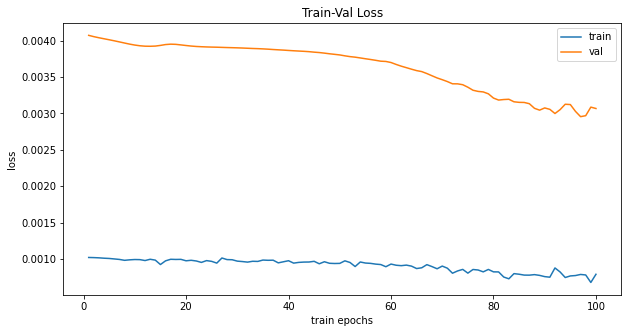

In [48]:
#6.Let's plot the training validation progress using the returned values, that is loss_hist and metric_hist
num_epochs = params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("loss")
plt.xlabel("train epochs")
plt.legend()
plt.show()

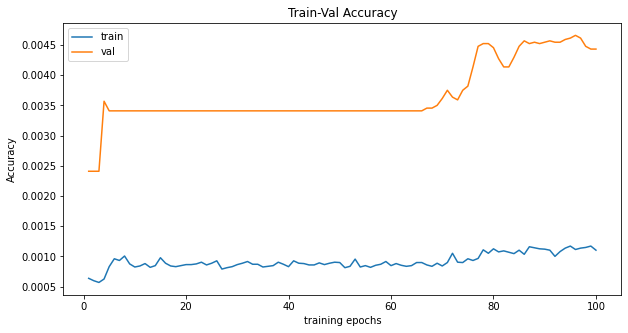

In [49]:
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("training epochs")
plt.legend()
plt.show()

In [50]:
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

params_train = {
    "num_epochs":20,
    "loss_func":loss_func,
    "optimizer":opt,
    "train_dl":train_dl,
    "val_dl":val_dl,
    "sanity_check":False,
    "lr_scheduler":lr_scheduler,
    "path2weights":r"D:\my file\ptcv\ptcv2\models\weights1.pt"
}

#train and validate the model
cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/19, current lr 0.000300
Copied best model weights!
train loss 0.461989, dev loss 0.441225, accuracy 0.80, duration 189.0828 sec
Epoch 1/19, current lr 0.000300
Copied best model weights!
train loss 0.436250, dev loss 0.431059, accuracy 0.81, duration 170.5184 sec
Epoch 2/19, current lr 0.000300
Copied best model weights!
train loss 0.416846, dev loss 0.400815, accuracy 0.82, duration 160.5618 sec
Epoch 3/19, current lr 0.000300
Copied best model weights!
train loss 0.405636, dev loss 0.388903, accuracy 0.83, duration 168.9133 sec
Epoch 4/19, current lr 0.000300
Copied best model weights!
train loss 0.389976, dev loss 0.378715, accuracy 0.83, duration 145.2917 sec
Epoch 5/19, current lr 0.000300
Copied best model weights!
train loss 0.378622, dev loss 0.369479, accuracy 0.84, duration 144.0316 sec
Epoch 6/19, current lr 0.000300
Copied best model weights!
train loss 0.364405, dev loss 0.369028, accuracy 0.84, duration 143.6405 sec
Epoch 7/19, current lr 0.000300
Copied best mode

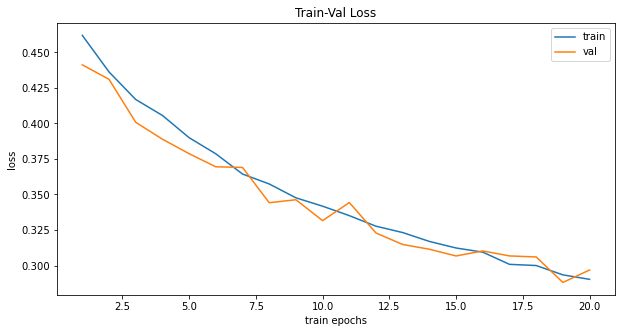

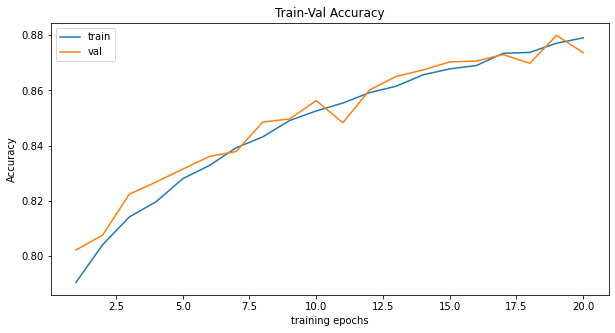

In [51]:
#The plots of training process can be seen as follows
num_epochs = params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("loss")
plt.xlabel("train epochs")
plt.legend()
plt.show()

plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("training epochs")
plt.legend()
plt.show()

# Deploying the model